## CS 505 Homework 05: Recurrent Neural Networks

RESOURCES: I used the resources posted along with the pytorch documentation and chat-gpt.

In [1]:
import math
import string
import numpy as np
from numpy.random import shuffle, seed, choice, randint,rand,normal,permutation
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from copy import deepcopy
from os import device_encoding


## Problem One: Character-Level Generative Model (20 pts)

In [19]:
## TEXT INPUT & DATA PROCESSING ##

# Reading File
with open("data/BSTExperiment.java.txt", "r") as text_file:
    text = text_file.read()[:100]

# 1-in-k en/decoders
chars_in_text = sorted(list(set(text)))
num_chars = len(chars_in_text)

def char2int(c):
    return chars_in_text.index(c)

def int2char(i):
    return chars_in_text[i]

# Creating input and target sample sequences
sample_len = 10
input_seq , target_seq = [], []

for k in range(len(text)-sample_len+1):
    # encoding seqs and offsetting target seq by 1
    input_seq.append( [char2int(ch) for ch in text[k:k+sample_len-1]])
    target_seq.append([char2int(ch) for ch in text[k+1:k+sample_len]])

# One-Hot Encoding & convert to tensors
def int2OneHot(X,size):
    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp
    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')

def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

input_seq = seq2OneHot(input_seq,size=num_chars)
target_seq = seq2OneHot(target_seq,size=num_chars)

input_seq = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq = torch.Tensor(target_seq).type(torch.DoubleTensor)

# Dataset creation
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)
batch_size = 128
data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

# Check for GPU, else use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [20]:
## MODEL ##

class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,dropout):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=dropout,batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        hidden_state_size = x.size(0)
        x = x.to(torch.double)

        h0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)
        c0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)

        self.lstm = self.lstm.double()
        self.fc1 = self.fc1.double()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hx,cx) = self.lstm(x, (h0,c0))

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)

        return out

Model(
  (lstm): LSTM(39, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=39, bias=True)
)


100%|██████████| 10/10 [00:00<00:00, 17.15it/s]


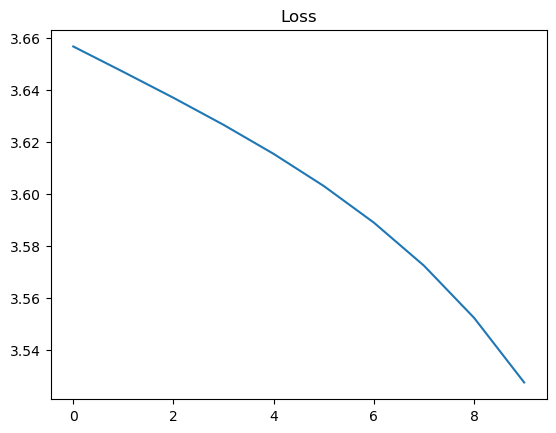

In [22]:
## TRAINING ##

# Instantiate Model
model = Model(input_size=num_chars, output_size=num_chars, hidden_dim=256, n_layers=1,dropout=0.0)
print(model)
model = model.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0)
num_epochs = 10

losses = []

model.train()

for epoch in tqdm(range(num_epochs)):

    for input_seq_batch,target_seq_batch in data_loader:
        input_seq_batch = input_seq_batch.to(device)
        target_seq_batch = target_seq_batch.to(device)
        optimizer.zero_grad()
        target_seq_hat = model(input_seq_batch)
        loss = loss_fn(target_seq_hat,target_seq_batch.view(-1,num_chars))
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

plt.title('Loss')
plt.plot(losses)

Analysis:

## Problem Two:  Word-Level Generative Model (40 pts)

Analysis:

## Problem Three:  Part-of-Speech Tagging (40 pts)

Analysis: